In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from weighted_kde import *
import tweet_tokenizer

In [2]:
def load_tweets(tweets_attributes_file, tweets_text_file):
    df = pd.read_csv(tweets_attributes_file, index_col=0)
    text = []
    with open(tweets_text_file, 'r') as f:
        for line in f:
            text.append(line)
    df['text'] = text
    return df

In [3]:
# Load tweet data
tweets_attributes_file = 'sandy_tweets_attributes_rev_geocoded_formatted_timestamps.csv'
tweets_text_file = 'sandy_tweets_text_tokenized.txt'

df = load_tweets(tweets_attributes_file, tweets_text_file)
#df = pd.read_csv(open('sandy_tweets_1.csv'), encoding='utf-8', engine='c')
df.head()

,tweet_id,user_id,retweet_count,time_stamp,longitude,latitude,state,county,text
0,260244125050363904,295902181,0,2012-10-22 05:00:09,-74.078101,40.735218,New Jersey,Hudson County,all i wish is to be better than yesterday and ...
1,260244177412042752,85314436,0,2012-10-22 05:00:21,-81.505790,33.460462,South Carolina,Barnwell County,@imSunnyAF yesssss lawd\n
2,260244177105850368,239968255,0,2012-10-22 05:00:21,-77.099999,39.344184,Maryland,Carroll County,"""Waiting for something better , a better you ...."
3,260244156729942016,703352862,0,2012-10-22 05:00:17,-80.907470,39.618102,West Virginia,Tyler County,Cool right ? #plainoldshirt http://t.co/B55dMS...
4,260244145694728192,581488152,0,2012-10-22 05:00:14,-76.579826,39.816450,Pennsylvania,York County,#10PeopleYouTrulyLove My son\n


In [4]:
len(df)

4779087

In [5]:
# Replace missing value in 'county' column by empty string. e.g. Washington D.C.
df['county'] = df['county'].replace(np.nan,'', regex=True)

In [6]:
# Groupby state-conunty pairs and save counts in a new column
# See http://stackoverflow.com/questions/17432944/python-pandas-error-when-doing-groupby-counts

#df['county_tweet_count'] = df.groupby(['state', 'county']).transform('count')
df['county_tweet_count'] = df.groupby(['state', 'county'])['tweet_id'].transform('count')

# Test print
print (len(df[df['state']+df['county'] == 'New JerseyHudson County']))
df.head(6)

52264


,tweet_id,user_id,retweet_count,time_stamp,longitude,latitude,state,county,text,county_tweet_count
0,260244125050363904,295902181,0,2012-10-22 05:00:09,-74.078101,40.735218,New Jersey,Hudson County,all i wish is to be better than yesterday and ...,52264
1,260244177412042752,85314436,0,2012-10-22 05:00:21,-81.505790,33.460462,South Carolina,Barnwell County,@imSunnyAF yesssss lawd\n,1375
2,260244177105850368,239968255,0,2012-10-22 05:00:21,-77.099999,39.344184,Maryland,Carroll County,"""Waiting for something better , a better you ....",7707
3,260244156729942016,703352862,0,2012-10-22 05:00:17,-80.907470,39.618102,West Virginia,Tyler County,Cool right ? #plainoldshirt http://t.co/B55dMS...,175
4,260244145694728192,581488152,0,2012-10-22 05:00:14,-76.579826,39.816450,Pennsylvania,York County,#10PeopleYouTrulyLove My son\n,20191
5,260244141139701760,80608282,1,2012-10-22 05:00:13,-84.472785,39.147755,Ohio,Hamilton County,Mortal kombat ! ! ! ! ! ! @JoeMoDavis #happybi...,51632


In [7]:
# Filter out Sandy related tweets'
#sandy_keywords = ['sandy', 'hurricane', 'storm', 'frankenstorm', 
#                  'power', 'no power', 'blackout',
#                  'gas', 'flooding', 'recovery', 
#                  'weather', 'climate', 'climate change', 'stay safe', 'FEMA']
#sandy_keywords = ['sandy', 'hurricane', 'hurricanesandy', 'frankenstorm', 
#                  'power outage', 'no power', 'blackout', 'no electricity', 'no light',
#                  'no gas', 'flooding',
#                  'climate change', 'fema', 'red cross']
sandy_keywords = ['sandy', 'hurricane', 'hurricanesandy', 'storm', 'frankenstorm']
sandy_keywords = sandy_keywords + ['#'+kw for kw in sandy_keywords]

pattern = ' ' + ' | '.join(sandy_keywords) + ' '
print (pattern)
df_filt = df[df['text'].str.contains(pattern)]

 sandy | hurricane | hurricanesandy | storm | frankenstorm | #sandy | #hurricane | #hurricanesandy | #storm | #frankenstorm 


In [8]:
print ('Total number of Sandy related tweets: %d' % len(df_filt))

Total number of Sandy related tweets: 54105


In [9]:
df_filt.head()

,tweet_id,user_id,retweet_count,time_stamp,longitude,latitude,state,county,text,county_tweet_count
2233,260259374579204096,555599291,0,2012-10-22 06:00:44,-77.383514,37.129962,Virginia,City of Petersburg,Tribe storm :)\n,2307
3719,260276715958464512,741091694,0,2012-10-22 07:09:39,-79.147932,37.402037,Virginia,City of Lynchburg,"""Talkin to these kids , making laugh up a stor...",9961
3943,260290515403145216,360388255,0,2012-10-22 08:04:29,-80.015212,40.430596,Pennsylvania,Allegheny County,All I see is a storm that you'll get lost in ....,77561
7303,260350662867562497,529698640,0,2012-10-22 12:03:29,-75.238252,39.953538,Pennsylvania,Delaware County,http://t.co/BhhL8usJ praise GOD n the storm . ...,53618
10147,260366743153823745,39651540,0,2012-10-22 13:07:23,-75.586010,39.945970,Pennsylvania,Chester County,@BigJoeBastardi what are water temps off e coa...,20863


### Matplotlib plots

In [10]:
# Map Sandy related Twitter activity using basemap

# Import matplotlib and Basemap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap

#import shapefile   

# Set iPython to display visualization inline
%matplotlib inline

In [33]:
from scipy import stats

def get_shape_lines(map, ax):   
    r = shapefile.Reader(r"./tiger_shape_files/cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
    shapes = r.shapes()
    records = r.records()
    
    for record, shape in zip(records,shapes):
        lons,lats = zip(*shape.points)
        data = np.array(map(lons, lats)).T
     
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])
     
        lines = LineCollection(segs,antialiaseds=(1,))
        #lines.set_facecolors(cm.jet(np.random.rand(1)))
        lines.set_edgecolors('grey')
        lines.set_linewidth(0.1)
        ax.add_collection(lines)
        
    return lines

        
def plot_geo_distbn_points_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, alpha=0.005):
    # Create a figure of size (i.e. pretty big)
    fig = plt.figure(figsize=(10,5))

    # create base map
    map = Basemap(resolution='i', projection='merc', llcrnrlon=lon_min, llcrnrlat=lat_min,
                  urcrnrlon=lon_max,urcrnrlat=lat_max, lat_ts=(lat_min+lat_max)/2)

    ### load the shapefile, use the name 'states'
    ##map.readshapefile('st99_d00', name='states', drawbounds=True)

    map.drawcoastlines() # Draw the coastlines on the map
    map.drawcountries() # Draw country borders on the map
    #map.fillcontinents(color = '#888888') # Fill the land with grey
    map.drawmapboundary(fill_color='#f4f4f4') # Draw the map boundaries

    ###############################################
    #ax = plt.subplot(111)
    #lines = get_shape_lines(map, ax)
    #ax.add_collection(lines)
    ##############################################

    # Define our longitude and latitude points
    # Here we use only filtered coordinates
    x,y = map(filtered_lon_vals, filtered_lat_vals)

    rgba_colors = np.zeros((len(x),4))
    rgba_colors[:,2] = 1.0 # blue color
    rgba_colors[:,3] = alpha #alphas

    map.scatter(x, y, s=50, facecolor=rgba_colors, marker='o', lw=0)

    

def plot_geo_distbn_kde_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, weights):
    # Create a figure of size (i.e. pretty big)
    fig = plt.figure(figsize=(10,5))

    # create base map
    map = Basemap(resolution='i', projection='merc', llcrnrlon=lon_min, llcrnrlat=lat_min,
                  urcrnrlon=lon_max,urcrnrlat=lat_max, lat_ts=(lat_min+lat_max)/2)

    ### load the shapefile, use the name 'states'
    ##map.readshapefile('st99_d00', name='states', drawbounds=True)

    map.drawcoastlines() # Draw the coastlines on the map
    map.drawcountries() # Draw country borders on the map
    #map.fillcontinents(color = '#888888') # Fill the land with grey
    map.drawmapboundary(fill_color='#f4f4f4') # Draw the map boundaries

    ###############################################
    #ax = plt.subplot(111)
    #lines = get_shape_lines(map, ax)
    #ax.add_collection(lines)
    ##############################################

    # Compute 2D histogram
    # Constructs bins
    nx, ny = 50, 50
    # compute bins to histogram the data into
    x_all_min, y_all_min = map(lon_min, lat_min)
    x_all_max, y_all_max = map(lon_max, lat_max)
    x_bins = np.linspace(x_all_min, x_all_max, nx+1)
    y_bins = np.linspace(y_all_min, y_all_max, ny+1)

    # Define our longitude and latitude points
    # Here we use only filtered coordinates
    x,y = map(filtered_lon_vals, filtered_lat_vals)

    X, Y = np.meshgrid(x_bins, y_bins)   
    
    # Compute 2D KDE
    data = np.vstack([x, y])
    #kdensity = stats.gaussian_kde(data)#, bw_method = 'silverman')  
    kdensity = gaussian_kde(data, weights=weights)#, bw_method=kdensity.factor / 3.)#'silverman')
    grid = np.vstack([X.ravel(), Y.ravel()])
    Z = kdensity(grid)
    Z = np.reshape(Z, X.shape)

    map.imshow(Z, cmap=plt.cm.Blues, extent=[x_all_min, x_all_max, y_all_min, y_all_max])

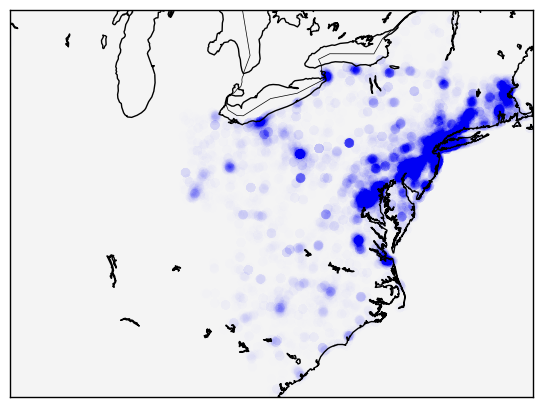

In [34]:
# Min and max lat-lon for whole dataset
lon_min, lon_max = df['longitude'].values.min(), df['longitude'].values.max()
lat_min, lat_max = df['latitude'].values.min(), df['latitude'].values.max()

# Map Sandy related Twitter activity using basemap
# Define our longitude and latitude points
# Here we use only power outage related data
filtered_lon_vals, filtered_lat_vals = df_filt['longitude'].values, df_filt['latitude'].values

median_flit_lon, median_flit_lat = np.median(filtered_lon_vals), np.median(filtered_lat_vals)
#lon_min, lon_max = median_flit_lon - 1, median_flit_lon + 1
#lat_min, lat_max = median_flit_lat - 1, median_flit_lat + 1

weights = 1.0/df_filt['county_tweet_count'].values
alpha = 0.005

plot_geo_distbn_points_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, alpha)

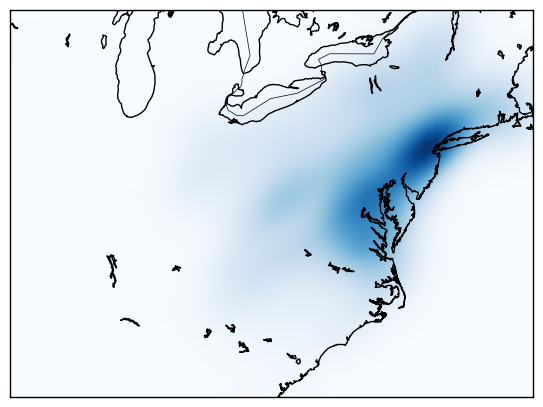

In [13]:
plot_geo_distbn_kde_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, weights)

### Plot sandy tweets distribution on daily basis

In [ ]:
df_filt['time_stamp'] = pd.to_datetime(df_filt['time_stamp'], infer_datetime_format=True)
df_filt.index = df_filt['time_stamp']

# Group the data by calender day
df_filt.resample('D').sum()

In [ ]:
for g in df_filt.resample('D').groups.iteritems():
    print (g)


In [ ]:
df_filt.resample('D').last()

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Date 2012-10-22 00:00:00
Date 2012-10-23 00:00:00
Date 2012-10-24 00:00:00
Date 2012-10-25 00:00:00
Date 2012-10-26 00:00:00
Date 2012-10-27 00:00:00
Date 2012-10-28 00:00:00
Date 2012-10-29 00:00:00
Date 2012-10-30 00:00:00
Date 2012-10-31 00:00:00
Date 2012-11-01 00:00:00
Date 2012-11-02 00:00:00


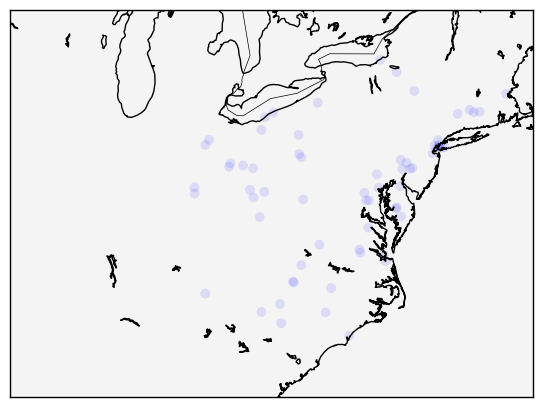

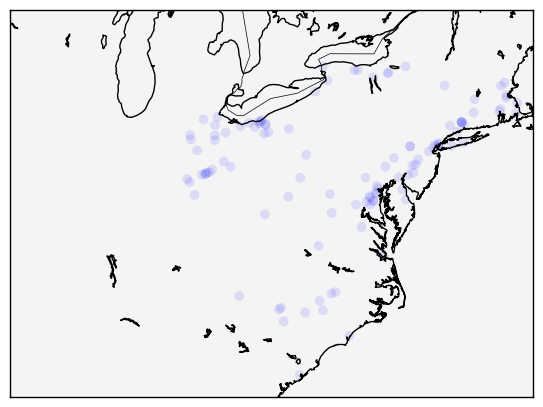

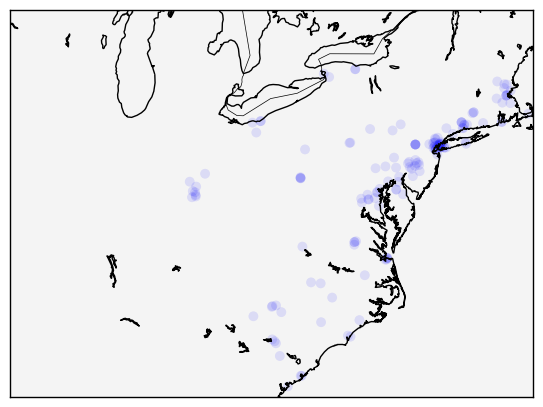

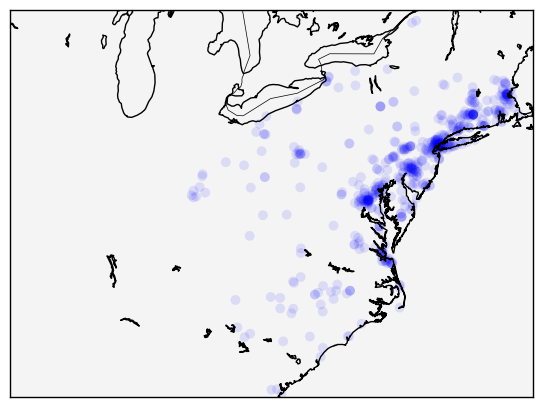

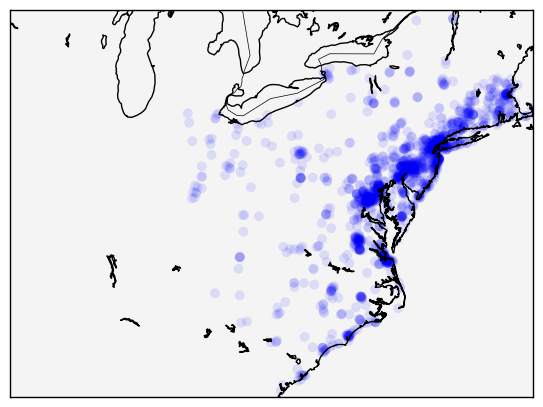

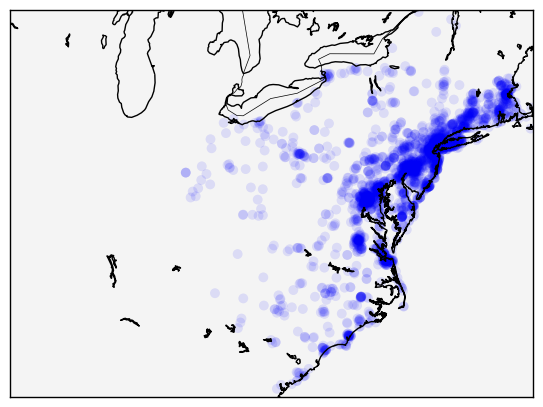

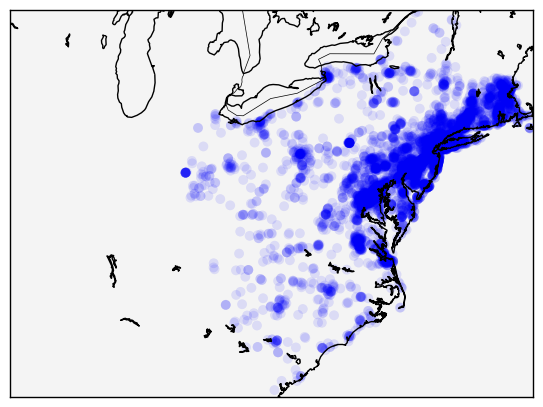

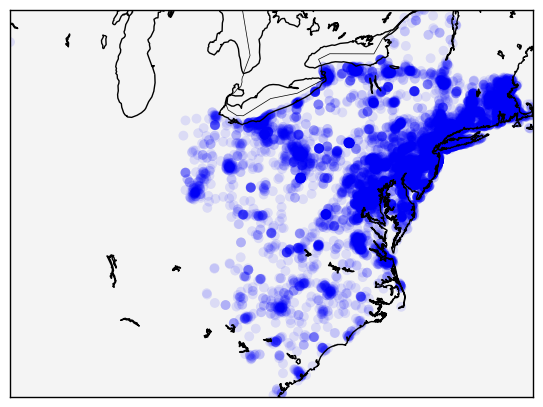

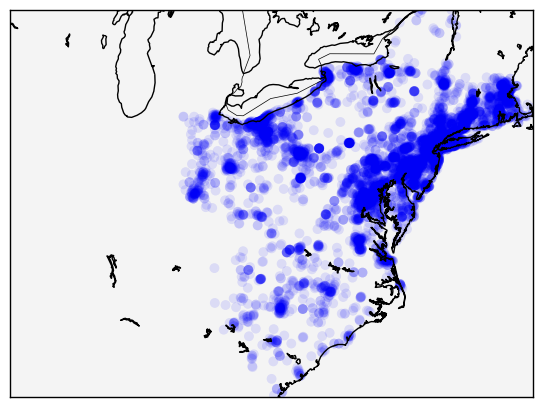

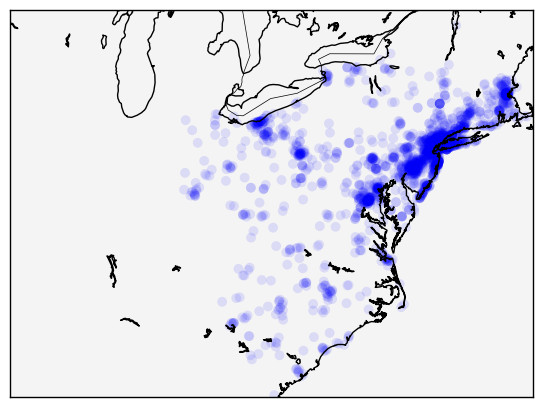

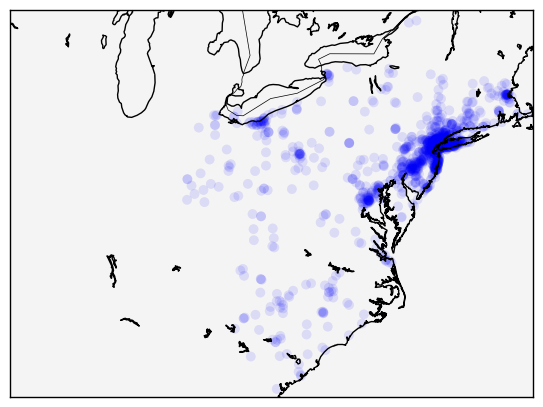

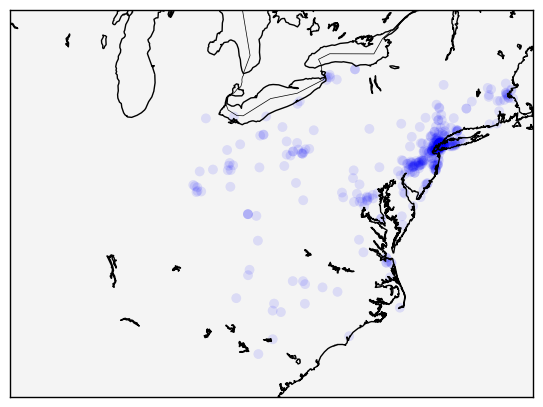

In [37]:
df_filt['time_stamp'] = pd.to_datetime(df_filt['time_stamp'], infer_datetime_format=True)
df_filt.index = df_filt['time_stamp']

for date, df_day in df_filt.groupby(pd.TimeGrouper(freq='1D')):
    print ('Date %s'% date)
    filtered_lon_vals, filtered_lat_vals = df_day['longitude'].values, df_day['latitude'].values
    df_day['county_tweet_count'] = df_day.groupby(['state', 'county'])['tweet_id'].transform('count')
    weights = 1.0/df_day['county_tweet_count'].values
    alpha = 0.1
    plot_geo_distbn_points_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, alpha)

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Date 2012-10-22 00:00:00
Date 2012-10-23 00:00:00
Date 2012-10-24 00:00:00
Date 2012-10-25 00:00:00
Date 2012-10-26 00:00:00
Date 2012-10-27 00:00:00
Date 2012-10-28 00:00:00
Date 2012-10-29 00:00:00
Date 2012-10-30 00:00:00
Date 2012-10-31 00:00:00
Date 2012-11-01 00:00:00
Date 2012-11-02 00:00:00


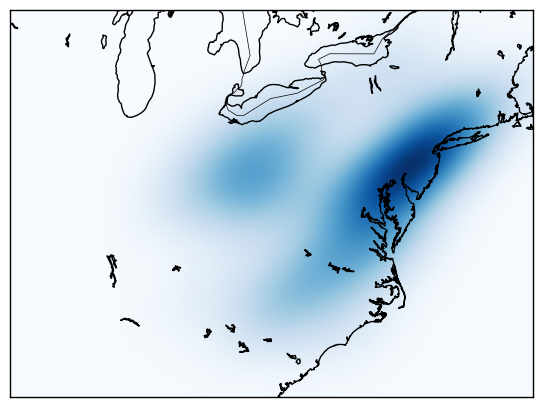

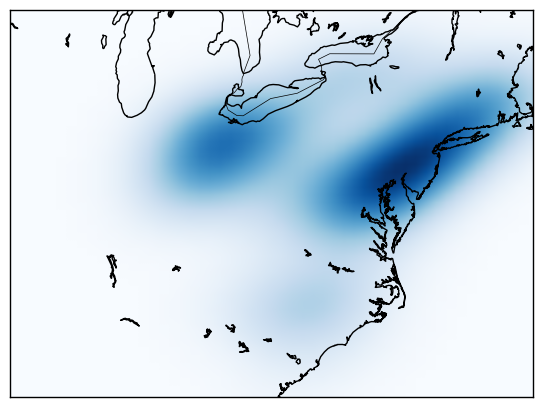

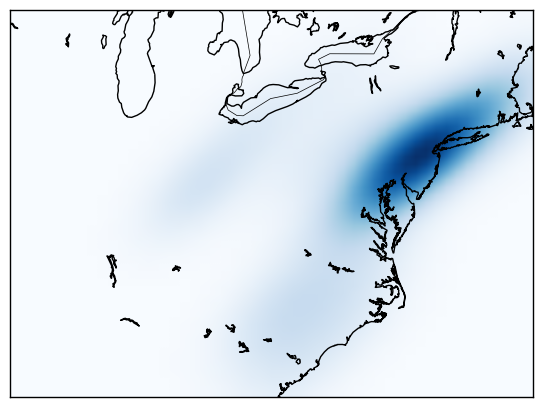

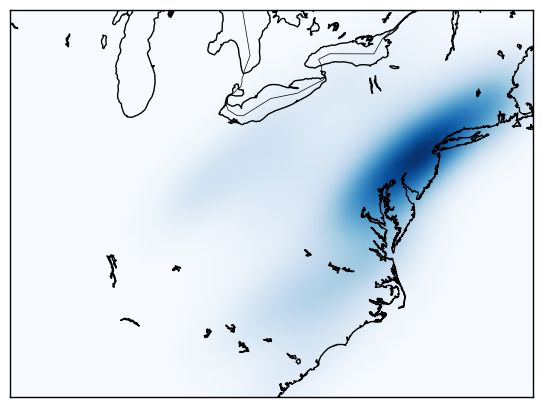

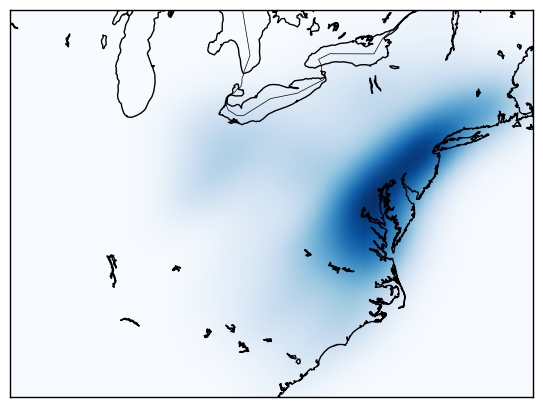

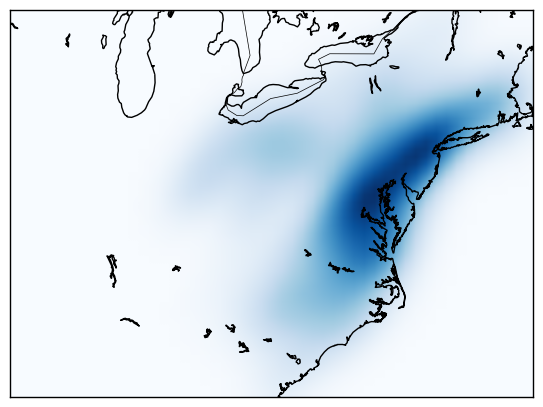

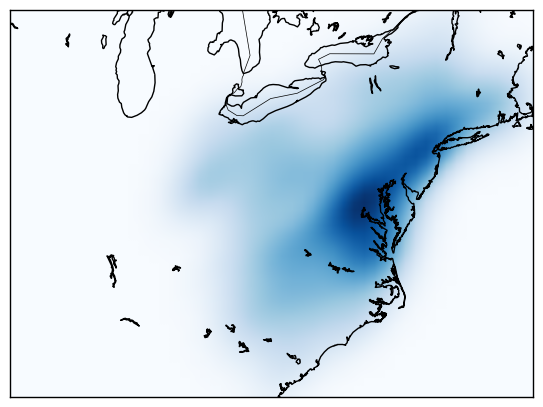

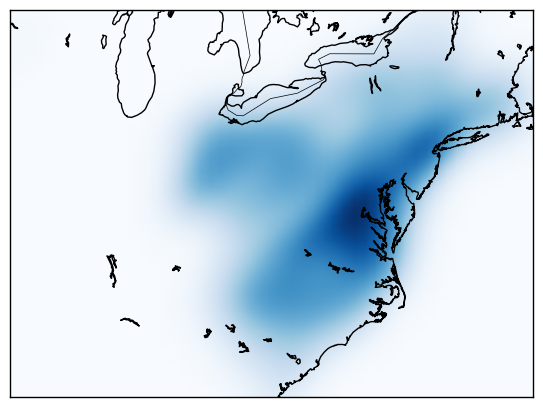

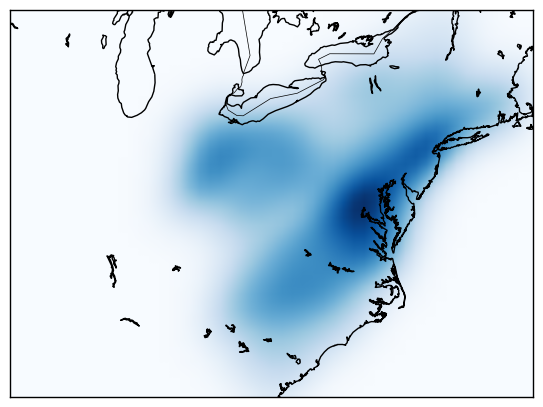

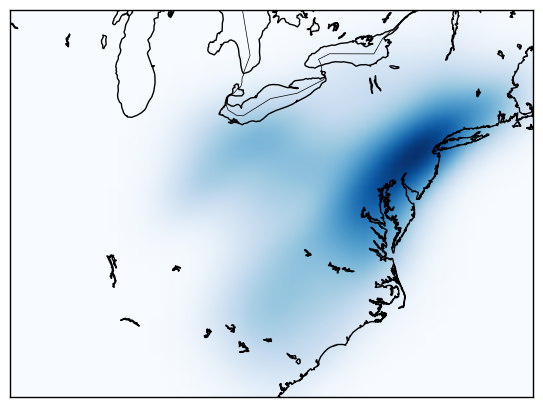

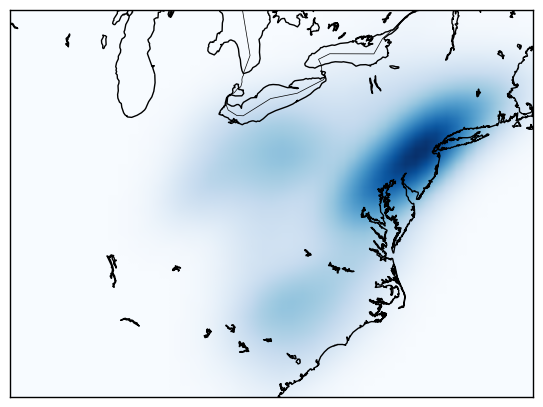

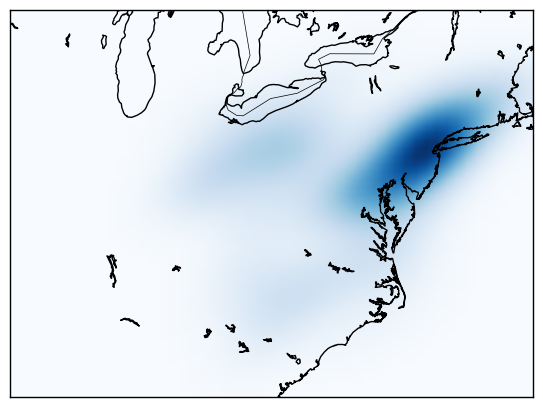

In [39]:
df_filt['time_stamp'] = pd.to_datetime(df_filt['time_stamp'], infer_datetime_format=True)
df_filt.index = df_filt['time_stamp']

for date, df_day in df_filt.groupby(pd.TimeGrouper(freq='1D')):
    print ('Date %s'% date)
    filtered_lon_vals, filtered_lat_vals = df_day['longitude'].values, df_day['latitude'].values
    df_day['county_tweet_count'] = df_day.groupby(['state', 'county'])['tweet_id'].transform('count')
    weights = 1.0/df_day['county_tweet_count'].values
    plot_geo_distbn_kde_basemap(lon_min, lon_max, lat_min, lat_max, filtered_lon_vals, filtered_lat_vals, weights)